# Test of Parameterized c-transform for semi-discrete OT

In order to install KeOps, see http://kernel-operations.io/keops/python/installation.html

## Imports

In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

from pykeops.torch import LazyTensor

import time
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor
device = torch.device('cpu')
print(device)

normalize_cost = True

cpu


## Functions for Regularized Optimal Transport

In [2]:
def lossfunwokeops(x,y,v,nu,ep=0, batch_size=None):
    yt = y.transpose(1,0)
    sx2 = torch.sum(x**2,1,keepdim=True)
    sy2 = torch.sum(yt**2,0,keepdim=True)
    normcst = sy2.mean()
    
    if batch_size is None:
        sy2b = sy2
        ytb = yt
        yb = y
        nub = nu
        vb = v[None,:]
    else:
        i = torch.randint(0,y.shape[0],(batch_size,))
        sy2b = sy2[:,i]
        ytb = yt[:,i]
        yb = y[i,:]
        nub = nu[i]
        vb = v[None,i]
    cxy = sx2 +  sy2b - 2*torch.matmul(x,ytb)
    if normalize_cost:
        cxy = cxy / normcst # cost normalization
    rmv = cxy - vb
    
    if ep>0:
        rmve = -rmv/ep + nub[None,:].log()
        d = torch.mean(-ep*torch.logsumexp(rmve,1)) + torch.dot(v,nu)        
    else:
        d = torch.mean(torch.min(rmv,1)[0]) + torch.dot(v,nu)
    return -d

# Optimize parameters of optimal transport
def ot_batch_wokeops(x, y, nu, ep=0, n_iter = 100, lr=1, batch_size=None, print_loss=False, compute_total_loss=False):
    v = torch.zeros(y.shape[0], requires_grad=True, device=device) # initialize
    optimv = torch.optim.ASGD([v], lr=lr, alpha=0.5, t0=1)
    losslist = []
    for it in range(n_iter):
        loss = lossfunwokeops(x,y,v,nu,ep, batch_size=batch_size)
        optimv.zero_grad()
        loss.backward()
        optimv.step()
        if compute_total_loss:
            loss = lossfunwokeops(x,y,v,nu,ep, batch_size=None)
        losslist.append(loss)
        if print_loss:
            print('iter ', it, ', loss =', loss.item())
    vt = optimv.state[v]["ax"] 
    return vt, losslist


In [3]:
# Sinkhorn Version

def sinkhorn_iter(r,v,mu,nu,ep):
    vp = v[None,:]
    lu = (vp-r)/ep
    rmve = lu + nu[None,:].log()
    u = -ep*torch.logsumexp(rmve,1)      
    up = u[:,None]
    lv = (up-r)/ep
    rmve = lv + mu[:,None].log()
    v = -ep*torch.logsumexp(rmve,0)
    return v

# simple version
def sinkhorn_iter_simple(r,v,mu,nu,ep):
    u = -ep*torch.log(torch.sum(nu[None,:]*torch.exp((v[None,:]-r)/ep),1))
    v = -ep*torch.log(torch.sum(mu[:,None]*torch.exp((u[:,None]-r)/ep),0))
    return v


def sinkhorn(x, y, nu, ep=0, n_iter = 100, print_loss=False):
    mu = torch.ones(x.shape[0])/x.shape[0]
    yt = y.transpose(1,0)
    sx2 = torch.sum(x**2,1,keepdim=True)
    sy2 = torch.sum(yt**2,0,keepdim=True)
    r = sx2 + sy2 - 2*torch.matmul(x,yt)
    normcst = sy2.mean() # divide by the variance
    if normalize_cost:
        r = r / normcst # cost normalization
    v = torch.zeros(y.shape[0], device=device) # initialize
    losslist = []
    for it in range(n_iter):
        v = sinkhorn_iter(r,v,mu,nu,ep)
        #v = sinkhorn_iter_simple(r,v,mu,nu,ep)
        loss = lossfunwokeops(x,y,v,nu,ep, batch_size=None)
        losslist.append(loss)
        if print_loss:
            print('iter ', it, ', loss =', loss.item())
    return v, losslist


## Functions for SDOTNN

In [4]:
# Multi-Linear Perceptron Network
class Discriminator_MLP(torch.nn.Module): 
    """
    A three hidden-layer classification neural network
    """
    def __init__(self, n_in=784):
        super(Discriminator_MLP, self).__init__()
        n_out = 1
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_in, 512),
            nn.ReLU(True)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(512, 256),
            nn.ReLU(True)
        ).to(device)
        self.hidden2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(True)
        ).to(device)
        
        self.out = nn.Sequential(
            nn.Linear(128, n_out),
            #nn.Tanh()
        ).to(device)

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

# number of parameters
def number_parameters(net):
    n = 0
    for name, param in net.named_parameters():
        t = param.numel()
        n += t
        print(name, t)
    return n    


# entropic semi-discrete optimal transport with dual variable parameterized as a neural network
class entropic_SDOTNN(nn.Module):    
    def __init__(self, y, lambd, device):
        super(entropic_SDOTNN, self).__init__()
        # y is a tensor [N x d]
        self.N = y.shape[0]
        self.d = y.shape[1]
        self.y = y.requires_grad_(False)
        self.yt = y.transpose(1,0).requires_grad_(False).to(device)
        self.sy2 = torch.sum(self.yt**2,0,keepdim=True)
        self.psi = Discriminator_MLP(n_in=self.d).to(device) # MLP
        #self.psi = Discriminator_convnet(1, 32).to(device) # conv net 
        # self.psi.apply(weights_init)
        self.lambd = lambd
        self.normalization = self.sy2.mean() # divide by the variance
        print("valuenormalize=",self.normalization)
        #self.normalization = 0.3081 * self.yt.size(0) # Juju : use MNIST standard-deviation if NORMALIZE_MNIST=False
        #self.normalization = self.yt.size(0) # Antoine divides by the dimension

    def forward(self, input, batch_size=None):
        if batch_size is None:
            sy2b = self.sy2
            ytb = self.yt
            yb = self.y
            nub = nu
        else:
            i = torch.randint(0,self.N,(batch_size,))
            sy2b = self.sy2[:,i]
            ytb = self.yt[:,i]
            yb = self.y[i,:]  
            nub = nu[i]  
        cxy = torch.sum(input**2,1,keepdim=True) +  sy2b - 2*torch.matmul(input,ytb)
        #cxy = 10*cxy
        if normalize_cost:
            cxy = cxy / self.normalization # cost normalization
        psiyb = self.psi(yb).transpose(1,0) # MLP
        # psiyb = self.psi(self.yt.transpose(1,0).view(self.yt.shape[1], 1, 28, 28)) # conv net
        if self.lambd > 0:
            output = -self.lambd*torch.logsumexp((psiyb-cxy)/self.lambd + nub[None,:].log(),1) + torch.mean(psiyb)
        else:
            output = torch.min(cxy - psiyb,1)[0] + torch.mean(psiyb)
        return output
    
def train_discriminator(discriminator, optimizer, input_data, METHOD):
    optimizer.zero_grad()    
    semidiscrete_OT_dual = discriminator(input_data)  # compute the semi discrete OT loss
    loss = -torch.mean(semidiscrete_OT_dual) # minus because it is a maximization problem    
    loss.backward() 
    optimizer.step()    
    return loss

def otnn_batch(x, y, nu, ep=0, n_iter = 100, lr=1, alpha=0.8, batch_size=None, print_loss=False, compute_total_loss=False):
    discriminator = entropic_SDOTNN(y, ep, device)
    #print(discriminator)
    print("Nb of parameters for discriminator =  ", number_parameters(discriminator))
    #print(discriminator.parameters())
    
    # d_optimizer = optim.ASGD(discriminator.parameters(), lr=lr, alpha=alpha, t0=1)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.9, 0.999),)
    losslist = []
    for it in range(n_iter):
        d_optimizer.zero_grad()
        semidiscrete_OT_dual = discriminator(x, batch_size=batch_size)  # compute the semi discrete OT loss
        loss = -torch.mean(semidiscrete_OT_dual) # minus because it is a maximization problem    
        #print(loss.grad)
        loss.backward()
        d_optimizer.step()
        if compute_total_loss:
            semidiscrete_OT_dual = discriminator(x)  # compute the semi discrete OT loss
            loss = -torch.mean(semidiscrete_OT_dual) # minus because it is a maximization problem    
        losslist.append(loss)
        if print_loss:
            print('iter ', it, ', loss =', loss.item())
    
    vt = discriminator.psi(y).squeeze(1).detach()
    return vt, losslist


## A simple test

In [53]:
N = 1000   # source points
J = 100  # target points
d = 27    # dimensionality of the problem
x = torch.randn(N, d, device=device)
y = torch.randn(J, d, device=device)
nu = torch.ones(J, device=device)/J

lmb = '0.001'
ep = float(lmb)
niter_psi = 1000
print(ep)

print(device)

0.001
cpu


valuenormalize= tensor(27.4584)
psi.hidden0.0.weight 13824
psi.hidden0.0.bias 512
psi.hidden1.0.weight 131072
psi.hidden1.0.bias 256
psi.hidden2.0.weight 32768
psi.hidden2.0.bias 128
psi.out.0.weight 128
psi.out.0.bias 1
Nb of parameters for discriminator =   178689


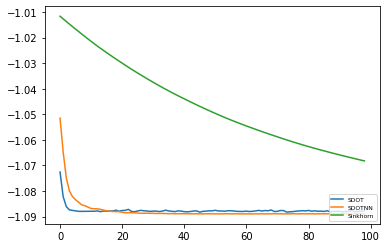

In [56]:
# NB: the setting of the learning rate is crucial in ot_batch_wokeops!!!
# In contrast, with otnn_batch, the value lr=0.5 seems quasi optimal
# In otnn_batch, one can attain a slightly better value by using ADAM (lr=0.001), but still not as good as ASGD.
# It seems that ADAM gets stuck in local minima.

t0 = time.time()
(v1,loss1) = ot_batch_wokeops(x,y,nu,ep,n_iter=niter_psi, lr=10, batch_size=None, compute_total_loss=True, print_loss=False)
#(v1,loss1) = ot_batch_wokeops(x,y,nu,ep,n_iter=niter_psi, lr=1, batch_size=40, print_loss=False, compute_total_loss=True)
elapsed_time = time.time()-t0 

# print("SDOT : ", elapsed_time, ' seconds')
# print("Final loss = ",lossfunwokeops(x,y,v1,nu,ep))
# plt.plot(loss1)
# plt.show()

t0 = time.time()
(v2,loss2) = otnn_batch(x,y,nu,ep,lr=0.001, alpha=0.8, n_iter=niter_psi, batch_size=None, compute_total_loss=True, print_loss=False)
elapsed_time = time.time()-t0 

# print("SDOTNN : ", elapsed_time, ' seconds')
# print("Final loss = ",lossfunwokeops(x,y,v2,nu,ep))
# plt.plot(loss2)
# plt.show()


# Sinkhorn
t0 = time.time()
(v3,loss3) = sinkhorn(x, y, nu, ep, n_iter = niter_psi, print_loss=False)
elapsed_time = time.time()-t0 

# print("Sinkhorn : ", elapsed_time, ' seconds')
# print("Final loss = ",lossfunwokeops(x,y,v3,nu,ep))
# print("v3=",v3)
# plt.plot(loss3)
# plt.show()

indmax = 100
plt.plot(loss1[1:indmax],label='SDOT')
plt.plot(loss2[1:indmax],label='SDOTNN')
plt.plot(loss3[1:indmax],label='Sinkhorn')
plt.legend(loc=4,fontsize=6)

plt.show()

#print(loss3[0:10],'\n')
#print(v1-v1.mean(),'\n')
#print(v2-v2.mean(),'\n')

## Load MNIST

image shape :  torch.Size([28, 28])


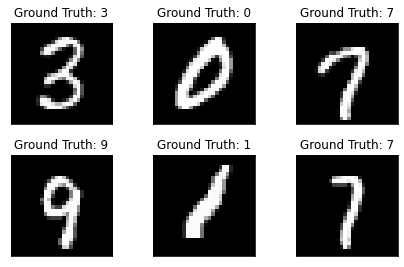

In [5]:
USE_FullDataset = True
batch_size_train = 60000 # max is 60k

params = {'batch_size': batch_size_train,
          'shuffle': True,
          'num_workers': 1}


NORMALIZE_MNIST = False # False (best) : range is in [0,1] -> use Sigmoid() for the generator 
# if True : mean=0, and std = 1 -> use Tanh() for the generator

import torchvision
if NORMALIZE_MNIST:
    train_loader = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST('./dataset', train=True, download=True,
                                 transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307,), (0.3081,)) # s.t. avg is 0 and std is 1
                                 ])),
      #batch_size=batch_size_train, shuffle=True)
        **params)
else :
    train_loader = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST('./dataset', train=True, download=True,
                                 transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor()
                                 ])),
      #batch_size=batch_size_train, shuffle=True)
        **params)


examples = enumerate(train_loader)
batch_idx, (train_data, train_targets) = next(examples)
print("image shape : ", train_data[1][0].shape)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(train_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(train_targets[i]))
    plt.xticks([])
    plt.yticks([])

        

def images_to_vectors(images):
    return images.view(images.size(0), 784).to(device)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)      

def noise(size):
    # n = torch.randn(size, 100, 1, 1, device=device)
    n = Variable(-1+2*torch.rand((size, 100), device=device))
    return n

def batch_imshow(vector_batch):
  imgs = vectors_to_images(vector_batch).clone().detach()
  fig, axs = plt.subplots(1, 10)
  for i in range(10):
    axs[i].imshow(imgs[i,0,:,:], cmap='gray', interpolation='none')
    axs[i].axis('off')
  plt.show()
  return



## Define CNN generator

In [6]:
class Generator_DCGAN_MNIST(nn.Module):
    def __init__(self, nc=1, nz=100, ngf=64, NORMALIZE_MNIST=False, ngpu=1):
        super(Generator_DCGAN_MNIST, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf*4, 3, 2, 0, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # state size. (ngf*4) x 3 x 3
            nn.ConvTranspose2d(ngf*4, ngf*2, 3, 2, 0, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d(ngf*2, ngf, 3, 2, 0, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(ngf, nc, 3, 2, 2, 1, bias=False),
            # state size. (nc) x 28 x 28
        )

        if NORMALIZE_MNIST:
            self.postp = nn.Tanh()
        else :
            self.postp = nn.Sigmoid()
        
    def forward(self, input):
        output = self.main(input.view(input.size(0),input.size(1),1,1))
        output = self.postp(output)
        return output

# ASGD with varying batches

In [7]:
    
batch_size_fake = 200

# for reproducibility
import random
random.seed(2020)
torch.manual_seed(2020)

generator = Generator_DCGAN_MNIST().to(device)
x = generator(noise(batch_size_fake)).view(batch_size_fake,28*28).detach() 

y = images_to_vectors(train_data)
print(x.shape)
print(y.shape)
ny = y.shape[0]
nu = torch.ones(ny)/ny
niter_psi = 100

torch.Size([200, 784])
torch.Size([60000, 784])


In [20]:
lmb = '0.100'
ep = float(lmb)
niter_psi = 100
print(ep)

0.1


In [21]:
# for reproducibility
import random
random.seed(2020)
torch.manual_seed(2020)

lr = 5
v = torch.zeros(y.shape[0], requires_grad=True, device=device) # initialize
optimv = torch.optim.ASGD([v], lr=lr, alpha=0.5, t0=1)
losslist = []
for it in range(niter_psi):
    x = generator(noise(batch_size_fake)).view(batch_size_fake,28*28).detach() 
    loss = lossfunwokeops(x,y,v,nu,ep, batch_size=None)
    optimv.zero_grad()
    loss.backward()
    optimv.step()
    losslist.append(loss)
v1 = optimv.state[v]["ax"] 
loss1 = losslist

In [22]:
# for reproducibility
import random
random.seed(2020)
torch.manual_seed(2020)

discriminator = entropic_SDOTNN(y, lambd=ep, device=device)
print("Nb of parameters for discriminator =  ", number_parameters(discriminator))

d_optimizer = optim.ASGD(discriminator.parameters(), lr=0.1, alpha=0.8, t0=1)
#d_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)

# other optimizers that lead bad results:
# d_optimizer = torch.optim.RMSprop(discriminator.parameters(), lr=0.01, alpha=0.99)
# d_optimizer = torch.optim.Adagrad(discriminator.parameters(), lr=0.001, lr_decay=0)                    
    
losslist = []
for it in range(niter_psi):
    d_optimizer.zero_grad()
    x = generator(noise(batch_size_fake)).view(batch_size_fake,28*28).detach() 
    semidiscrete_OT_dual = discriminator(x, batch_size=None)  # compute the semi discrete OT loss
    loss = -torch.mean(semidiscrete_OT_dual) # minus because it is a maximization problem    
    loss.backward()
    d_optimizer.step()
    losslist.append(loss)

v2 = discriminator.psi(y).squeeze(1).detach()
loss2 = losslist

valuenormalize= tensor(87.8100)
psi.hidden0.0.weight 401408
psi.hidden0.0.bias 512
psi.hidden1.0.weight 131072
psi.hidden1.0.bias 256
psi.hidden2.0.weight 32768
psi.hidden2.0.bias 128
psi.out.0.weight 128
psi.out.0.bias 1
Nb of parameters for discriminator =   566273


In [23]:
# for reproducibility
import random
random.seed(2020)
torch.manual_seed(2020)

v = torch.zeros(y.shape[0], requires_grad=True, device=device) # initialize
optimv = torch.optim.Adam([v], lr=0.001)
losslist = []
for it in range(niter_psi):
    x = generator(noise(batch_size_fake)).view(batch_size_fake,28*28).detach() 
    loss = lossfunwokeops(x,y,v,nu,ep, batch_size=None)
    optimv.zero_grad()
    loss.backward()
    optimv.step()
    losslist.append(loss)
    
v3 = optimv.state[v]
loss3 = losslist

In [24]:
# for reproducibility
import random
random.seed(2020)
torch.manual_seed(2020)

discriminator = entropic_SDOTNN(y, lambd=ep, device=device)
print("Nb of parameters for discriminator =  ", number_parameters(discriminator))

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)

losslist = []
for it in range(niter_psi):
    d_optimizer.zero_grad()
    x = generator(noise(batch_size_fake)).view(batch_size_fake,28*28).detach() 
    semidiscrete_OT_dual = discriminator(x, batch_size=None)  # compute the semi discrete OT loss
    loss = -torch.mean(semidiscrete_OT_dual) # minus because it is a maximization problem    
    loss.backward()
    d_optimizer.step()
    losslist.append(loss)

v4 = discriminator.psi(y).squeeze(1).detach()
loss4 = losslist

valuenormalize= tensor(87.8100)
psi.hidden0.0.weight 401408
psi.hidden0.0.bias 512
psi.hidden1.0.weight 131072
psi.hidden1.0.bias 256
psi.hidden2.0.weight 32768
psi.hidden2.0.bias 128
psi.out.0.weight 128
psi.out.0.bias 1
Nb of parameters for discriminator =   566273


###  Plot curves

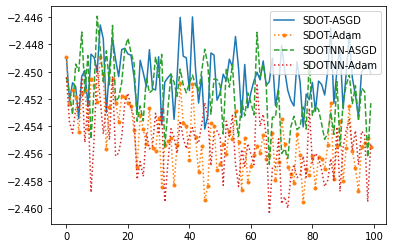

In [25]:

CONV_GEN = 'DCGAN'  # mistake: DCGAN actually!
batch_size = 'None'

fol = 'plots/'

indmax = 100
plt.plot(loss1[0:indmax],label='SDOT-ASGD')
plt.plot(loss3[0:indmax],':.',label='SDOT-Adam')
plt.plot(loss2[0:indmax],'--',label='SDOTNN-ASGD')
plt.plot(loss4[0:indmax],':',label='SDOTNN-Adam')
plt.legend(loc=1,fontsize=10)
plt.savefig(fol+'mnist_loss_dual_lmb='+lmb+'_'+CONV_GEN+'_batch'+batch_size+'.pdf')
plt.show()

## Test of SDOTNN with MNIST data AND fixed batch!!

In [7]:
    
batch_size_fake = 200

# for reproducibility
import random
random.seed(2020)
torch.manual_seed(2020)

# load trained generator :
#from generator import *
#generator = Generator_conv(1,100,32,NORMALIZE_MNIST=True).to(device)
#generator.load_state_dict(torch.load('./results_old/generator_SDOT_lmb=0.01_lrpsi=5.0_ConvNet_Full-MNIST__24-Jan-2022-20:23.pth', map_location=torch.device(device)))
#x = generator(noise(batch_size_fake)).view(batch_size_fake,28*28).detach() 

generator = Generator_DCGAN_MNIST().to(device)
x = generator(noise(batch_size_fake)).view(batch_size_fake,28*28).detach() 

y = images_to_vectors(train_data)
print(x.shape)
print(y.shape)
ny = y.shape[0]
nu = torch.ones(ny)/ny
niter_psi = 100

lmb = '0.001'
ep = float(lmb)
niter_psi = 100
print(ep)

torch.Size([200, 784])
torch.Size([60000, 784])
0.001


In [8]:
# SDOT
t0 = time.time()
(v1,loss1) = ot_batch_wokeops(x,y,nu,ep,lr=5,n_iter=niter_psi, print_loss=False)
#(v1,loss1) = ot_batch_wokeops(x,y,nu,ep,lr=5,n_iter=niter_psi, print_loss=False)
elapsed_time = time.time()-t0 

print("SDOT : ", elapsed_time, ' seconds')
print("Final loss = ",lossfunwokeops(x,y,v1,nu,ep))
# print("v1=",v1)
# plt.plot(loss1)
# plt.show()

# SDOTNN
t0 = time.time()
(v2,loss2) = otnn_batch(x,y,nu,ep,lr=0.1, alpha=0.8, n_iter=niter_psi, print_loss=False)
#(v2,loss2) = otnn_batch(x,y,nu,ep,lr=0.1, alpha=0.8, n_iter=niter_psi, batch_size=None, compute_total_loss=False, print_loss=False)
elapsed_time = time.time()-t0 

print("SDOTNN : ", elapsed_time, ' seconds')
print("Final loss = ",lossfunwokeops(x,y,v2,nu,ep))
print("v2=",v2)
# plt.plot(loss2)
# plt.show()

# Sinkhorn
t0 = time.time()
(v3,loss3) = sinkhorn(x, y, nu, ep, n_iter = 100, print_loss=False)
elapsed_time = time.time()-t0 

print("Sinkhorn : ", elapsed_time, ' seconds')
print("Final loss = ",lossfunwokeops(x,y,v3,nu,ep))
#print("v3=",v3)
# plt.plot(loss3)
# plt.show()

SDOT :  40.787665128707886  seconds
Final loss =  tensor(-2.3463)
valuenormalize= tensor(87.8100)
psi.hidden0.0.weight 401408
psi.hidden0.0.bias 512
psi.hidden1.0.weight 131072
psi.hidden1.0.bias 256
psi.hidden2.0.weight 32768
psi.hidden2.0.bias 128
psi.out.0.weight 128
psi.out.0.bias 1
Nb of parameters for discriminator =   566273
SDOTNN :  101.7667543888092  seconds
Final loss =  tensor(-2.3338)
v2= tensor([0.1980, 0.1594, 0.1577,  ..., 0.2160, 0.1639, 0.1657])
Sinkhorn :  50.858219146728516  seconds
Final loss =  tensor(-2.3824)


###  Plot curves

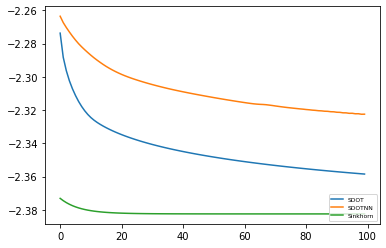

In [9]:

CONV_GEN = 'DCGAN'
batch_size = 'None'

fol = 'plots/'

indmax = 100
plt.plot(loss1[0:indmax],label='SDOT')
plt.plot(loss2[0:indmax],label='SDOTNN')
plt.plot(loss3[0:indmax],label='Sinkhorn')
plt.legend(loc=4,fontsize=6)
#plt.savefig(fol+'mnist_loss_dual_fixedbatch_lmb='+lmb+'_'+CONV_GEN+'_batch'+batch_size+'.pdf')
plt.show()

### Plot dual variable to check

In [ ]:
v1np = np.array(v3.detach())*1000
print(v1np - v1np.mean())
plt.plot(v1np)